In [31]:
import numpy as np
import simulation_manager, results_annalysis
import instance_genrerantion
import matplotlib.pyplot as plt
import time
import pandas as pd

In [32]:
def P_aug(N,bit): 
    P = np.zeros((N,N*bit))
    b = np.array([2**i for i in range(bit)])
    for i in range(N):
        debut = i*bit
        fin = debut + bit 
        P[i,debut:fin] = b 

    return P 

In [33]:
P_aug(4,3)

array([[1., 2., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 2., 4., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 2., 4., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 4.]])

In [34]:
def reduction_markovitz(sigma,mu,alpha,K,bit=1,penaly = 0):
    """
    From the covariance matrix and the excpected return vector returns the J and H 
    of the Ising mapping 

    ARGS: 
    sigma: covariance matrix 
    mu: excpected return vector
    alpha : aversion constant 
    K : The budget 
    penalty: If we add the constraint in the energy 
    Output: 
    J : 
    H: 
    """
    Bit_max = int(np.log2(K))+1
    N = len(mu) # Number of assets considered 
    U = np.ones(bit*N) 
    P = P_aug(N,bit)
    sigma_augmented = P.T @ sigma @ P
    mu_augmented = P.T @ mu 
    I_augmented = P.T @ np.ones(N)

    J = - (alpha/2)* sigma_augmented
    H = (alpha/2) * sigma_augmented @ U - mu_augmented - penaly*I_augmented
    np.fill_diagonal(J,0)


    return J,H



# **Testing the SB**

Defining $\Sigma$ and $\mu$

In [35]:
# Covariance matrix (example values)
sigma= np.array([[1.0, 1.2, 0.7], [1.2, 1.0, -1.9], [0.7, -1.9, 1.0]])

# Expected return vector (example values)
mu = np.array([0.2, 0.05, 0.17])



In [36]:
# import numpy as np

# # Generate random covariance matrix (100x100)
# sigma = np.random.rand(4, 4)
# sigma = np.dot(sigma, sigma.T)  # Make it symmetric
# sigma = sigma / np.max(np.abs(sigma))  # Normalize to control magnitude

# # Generate random expected return vector (length 100)
# mu = np.random.rand(4)
# mu = mu / np.sum(mu)  # Normalize so that the sum equals 1


In [37]:
# import numpy as np

# # Covariance matrix (example values)
# sigma = np.array([[1.0, 0.2, 0.1], [0.2, 0.8, 0.3], [0.1, 0.3, 0.6]])

# # Expected return vector (example values)
# mu = np.array([0.12, 0.08, 0.15])


In [38]:
J,H = reduction_markovitz(sigma,mu,alpha = 2,K=10,bit=3,penaly= 1)

In [39]:
np.log2(10)

3.321928094887362

In [40]:
eigs = np.linalg.eigvals(J)
ksi = 1/(eigs.max())
p_first = 1-ksi*np.real(eigs.max())
p_last = 1-ksi*np.real(eigs.min())
num_iterations = 1000
lag = 0

def pumpuing_rate(self, t):
    # return t/100
    if t<lag:
        return 0
    else:
        return 1 * p_last * (t-lag)/(num_iterations-lag)

In [41]:
manager = simulation_manager.SimulationManager(step_size=0.5, num_iterations=num_iterations, num_simulations=2, J=J, H=H, pumping_rate=pumpuing_rate, stopping_criterion=0.1, save_states_history=True, save_energies_history=True, n_threads=2, savetofile=False)

In [42]:
states, energies, last_states, last_TAC_states, last_sign_States, last_energies, last_TAC_energies, last_sign_energies, final_times, sign_times, TAC_times = manager.run_simulation()


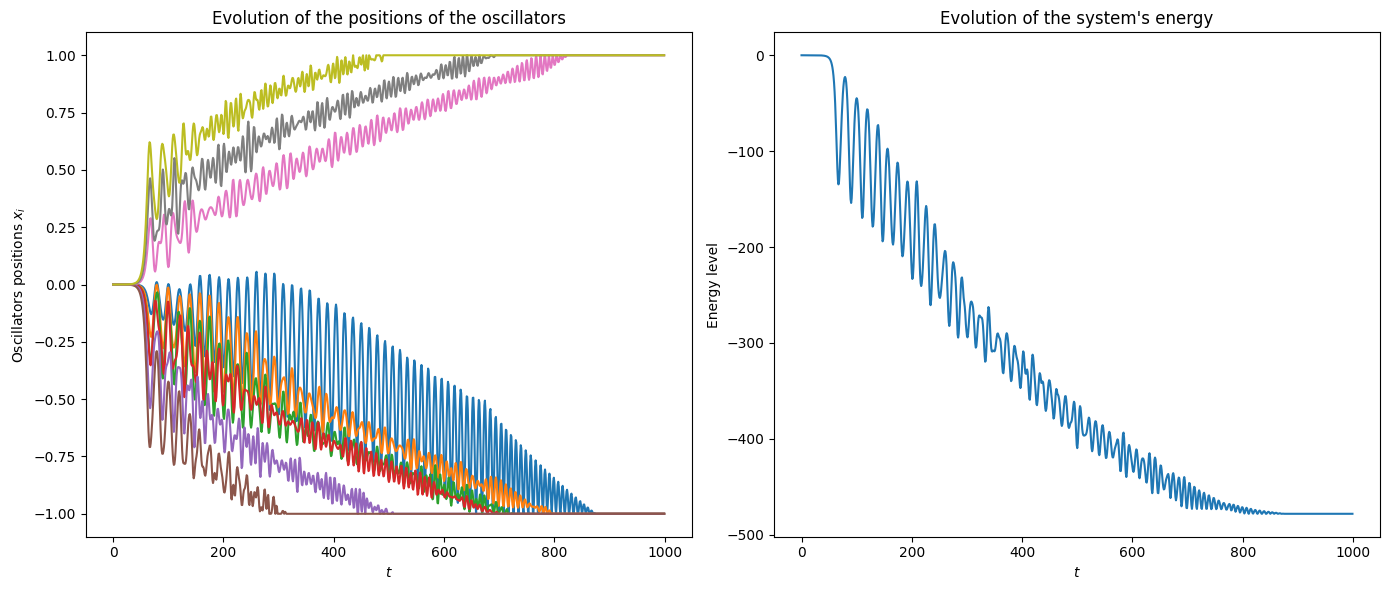

In [43]:
results_annalysis.complete_plot(states, energies, 0)


In [44]:
solution = np.sign(last_states[0, :, 0])
solution

array([-1., -1., -1., -1., -1., -1.,  1.,  1.,  1.])